In [1]:
import os
import sys
from IPython.display import clear_output
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# import the cfe model
import bmi_cfe
import cfe

In [2]:
# define working dir
working_dir = '/Users/Sophie/Desktop/CUAHSI/nextgen-form-eval/Calibration'

# define basin list dir
basin_dir = '/Users/Sophie/Desktop/CUAHSI/Data'
basin_filename = 'basin_list_516.txt'
basin_file = os.path.join(basin_dir,basin_filename)

# define config dir
config_dir = os.path.join(working_dir,'configs')

# define observation file dir
#obs_dir = os.path.join(working_dir,'usgs-streamflow')
obs_dir = '/Users/Sophie/Desktop/CUAHSI/Data'


In [3]:
# load basin list
with open(basin_file, "r") as f:
    basin_list = pd.read_csv(f, header=None)

###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/Data/01022500_hourly_nldas.csv. -----###
###----- nldas forcing data length: 52608------###
---------------- Current Timestep: 0----------------
rainfall_input:   0.0000 m. 

after rainfall et: 
rainfall_input:   0.0000 m 
total out vol:   0.0000 mm,

after soil et: 
rainfall_input:   0.0000 m 
total out vol:   0.0328 mm,

After direct runoff function: 
rain:   0.0000 mm,
runoff:   0.0000 mm,
residual:  0.0000 mm
runoff volume:   0.0000 mm,
infiltration volume:   0.0000 mm,

after previous step percolation: 
runoff volume:   0.0000 mm,
infiltration volume:   0.0000 mm,

after soil reservoir flux calculation: 
runoff volume:   0.0000 mm,
infiltration volume:   0.0000 mm,
total out vol.:  0.0328 mm

after gw reservoir flux calculation: 
runoff volume:   0.0000 mm,
infiltration volume:   0.0000 mm,

after giuh cascade: 
total out v

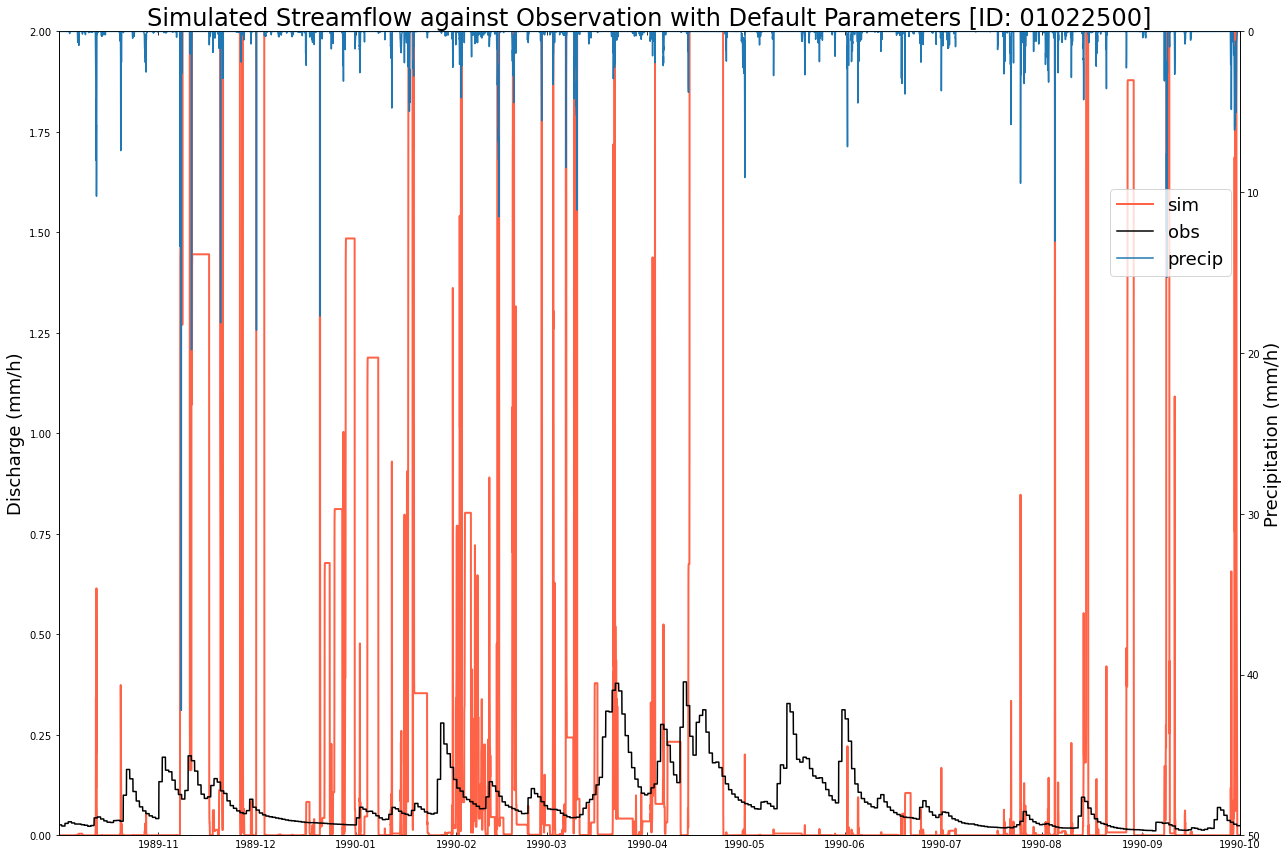

In [4]:
# Loop through each basin
for i in range(basin_list.shape[0]): 
# for i in range(20): 
    if i == 1 : break             # run for the first basin in the list

    # if i != 130: continue           # run for a specific basin in the list

    clear_output()
    
    g = basin_list[0][i]

    # locate config file
    config_filename = 'cat_' + str(g) + '_bmi_config_cfe.json'
    config_file = os.path.join(config_dir,config_filename)

    # ----------------------------------- Run the Model ----------------------------------- #

    cfemodel = bmi_cfe.BMI_CFE(config_file)
    print('###--------model succesfully setup----------###')

    scheme = "Schaake"

    cfemodel.initialize(param_vec = [], scheme = "Schaake")
    print('###--------model succesfully initialized----------###')

    with open(cfemodel.forcing_file, 'r') as f:
        df_forcing = pd.read_csv(f)
    print(f"###----- forcing_file loaded:{cfemodel.forcing_file}. -----###")

    # define the calibration period for nldas forcing and usgs streamflow obs.
    cal_start_idx_nldas = np.where(df_forcing['date']=='2007-10-01 00:00:00')
    cal_end_idx_nldas = np.where(df_forcing['date'].values=='2013-09-30 23:00:00')
    df_forcing = df_forcing.iloc[cal_start_idx_nldas[0][0]:cal_end_idx_nldas[0][0]+1,:]

    print('###----- nldas forcing data length: ' +  str(len(df_forcing['date'].values))+"------###")

    outputs=cfemodel.get_output_var_names()
    output_lists = {output:[] for output in outputs}

    for precip, pet in zip(df_forcing['total_precipitation'],df_forcing['potential_evaporation']):
        #print(f"###----------loaded precip, pet: {precip},{pet}.------------###")
        #sys.exit(1)
        cfemodel.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip/1000)   # kg/m2/h = mm/h -> m/h
        cfemodel.set_value('water_potential_evaporation_flux', pet/1000/3600) # kg/m2/h = mm/h -> m/s
        cfemodel.update()

        for output in outputs:
            output_lists[output].append(cfemodel.get_value(output))
        
    cfemodel.finalize(print_mass_balance=True)

    # ----------------------------------- Evaluate Results ----------------------------------- #
    # Load Observation file
    obs_filename = '0' + str(g) + '-usgs-hourly.csv'
    obs_file = os.path.join(obs_dir,obs_filename)

    data = pd.read_csv(obs_file)
    obs_data = data['QObs_CAMELS(mm/h)'].values
    eval_dates = data['date'].values
    dates = [pd.Timestamp(eval_dates[i]) for i in range(len(eval_dates))]

    # Export streamflow data
    sims = np.array(output_lists['land_surface_water__runoff_depth']) * 1000 

    fig, ax1 = plt.subplots(figsize = (18,12)) 
    p1, = ax1.plot(dates[0:8760],sims[0:8760],'tomato', linewidth = 2,label = "sim")
    p2, = ax1.plot(dates[0:8760],obs_data[0:8760],'k',label = "obs")
    ax1.set_ylabel('Discharge (mm/h)',fontsize = 18)
    ax1.set_ylim([0,2])
    ax1.margins(x=0)
    ax1.xaxis.set_ticks_position('both')
    ax1.xaxis.set_label_position('bottom')
    ax1.tick_params(axis="x",direction="in")
    ax2 = ax1.twinx()
    p3, = ax2.plot(dates[0:8760],df_forcing['total_precipitation'][0:8760],'tab:blue', label = "precip")
    ax2.set_ylim([50,0])
    ax2.margins(x=0)
    #ax2.invert_yaxis()
    ax2.set_ylabel('Precipitation (mm/h)',fontsize = 18)
    ax2.set_xlabel('Date', fontsize = 18)
    plt.legend(handles = [p1,p2,p3],fontsize = 18, loc='right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
    plt.title(f"Simulated Streamflow against Observation with Default Parameters [ID: 0{g}]", fontsize = 24)
    plt.tight_layout()
    plt.show()

In [5]:
cfemodel.soil_reservoir

{'is_exponential': False,
 'wilting_point_m': 0.09933623921621622,
 'storage_max_m': 0.7460044600810811,
 'coeff_primary': 0.0041794799663436525,
 'exponent_primary': 1.0,
 'storage_threshold_primary_m': 0.5032675905411451,
 'coeff_secondary': 0.01,
 'exponent_secondary': 1.0,
 'storage_threshold_secondary_m': 0.5032675905411451,
 'storage_m': 0.7071117178257592}

In [6]:
cfemodel.soil_params

{'bb': 8.013513513513514,
 'D': 2.0,
 'depth': 2.0,
 'mult': 1000.0,
 'satdk': 1.3156783783783787e-05,
 'satpsi': 0.1647076737162162,
 'slop': 0.08824091635135137,
 'smcmax': 0.37300223004054056,
 'wltsmc': 0.04966811960810811}

In [7]:
cfemodel._values["atmosphere_water__time_integral_of_precipitation_mass_flux"]

0.0